# Análisis Estadístico de Películas Blockbuster (1977-2019)
**Proyecto de Estadística Aplicada**

**Objetivo:** Analizar los factores que influyen en el éxito comercial de las películas blockbuster, respondiendo preguntas clave sobre presupuesto, recaudación, calificación, géneros y tendencias temporales.

**Preguntas de investigación:**

1- ¿Existe una relación significativa entre el presupuesto de una película y su recaudación mundial?

2- ¿La calificación de IMDb está asociada con la recaudación mundial?

3- ¿Podemos identificar clusters o grupos naturales de películas blockbuster según características de género, presupuesto y rating?

4- ¿Ha cambiado la recaudación promedio de los top-10 blockbusters a lo largo del tiempo?

**Fuente de datos:** Dataset propio de las 10 películas más taquilleras de cada año (1977-2019).

## 1. Importación de librerías generales

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualizaciones
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

## 2. Función para crear estructura de carpetas

In [2]:
def crear_estructura_carpetas():
    """
    Crea la estructura de carpetas para el proyecto
    """
    print("📁 CREANDO ESTRUCTURA DE CARPETAS...")
    
    carpetas = ['graphics', 'data', 'results']
    
    for carpeta in carpetas:
        if not os.path.exists(carpeta):
            os.makedirs(carpeta)
            print(f"   ✓ Carpeta creada: {carpeta}/")
        else:
            print(f"   ⓘ Carpeta ya existe: {carpeta}/")
    
    # Crear subcarpetas dentro de graphics
    subcarpetas_graphics = ['eda', 'pregunta1', 'pregunta2', 'pregunta3', 'pregunta4']
    
    for subcarpeta in subcarpetas_graphics:
        ruta_completa = os.path.join('graphics', subcarpeta)
        if not os.path.exists(ruta_completa):
            os.makedirs(ruta_completa)
            print(f"   ✓ Subcarpeta creada: {ruta_completa}/")
    
    print("✓ Estructura de carpetas lista\n")
    return True

## 3. Cargar, limpieza y transformación de datos

In [3]:
def cargar_datos(ruta_archivo='Blockbusters_2019-1977.csv'):
    """
    Carga el dataset de películas blockbuster
    """
    print("📂 CARGANDO DATOS...")
    try:
        # Intentar cargar desde la carpeta data
        ruta_data = os.path.join('data', ruta_archivo)
        if os.path.exists(ruta_data):
            df = pd.read_csv(ruta_data, encoding='latin1')
            print(f"   ✓ Dataset cargado desde: data/{ruta_archivo}")
        else:
            df = pd.read_csv(ruta_archivo, encoding='latin1')
            print(f"   ✓ Dataset cargado desde: {ruta_archivo}")
            
        print(f"   • {df.shape[0]} películas, {df.shape[1]} variables")
        return df
    except FileNotFoundError:
        print("❌ Error: Archivo no encontrado")
        return None

def limpiar_y_transformar(df):
    """
    Realiza limpieza y transformación de datos
    """
    print("\n🧹 LIMPIANDO Y TRANSFORMANDO DATOS...")
    
    # Crear copia para no modificar el original
    df_clean = df.copy()
    
    # 4.1 Limpieza de columnas monetarias
    print("   Limpiando columnas monetarias...")
    for col in ['film_budget', 'worldwide_gross', 'domestic_gross']:
        if col in df_clean.columns:
            # Convertir a string, eliminar comas y convertir a float
            df_clean[col] = (
                df_clean[col]
                .astype(str)
                .str.replace(',', '')
                .str.replace('$', '')
                .astype(float)
            )
            print(f"   ✓ {col}: Convertido a numérico")
    
    # 4.2 Creación de variables derivadas
    print("   Creando variables derivadas...")
    
    # ROI (Retorno de Inversión)
    df_clean['ROI'] = df_clean['worldwide_gross'] / df_clean['film_budget']
    df_clean['ROI_ratio'] = df_clean['worldwide_gross'] / df_clean['film_budget']
    
    # Década
    df_clean['decade'] = (df_clean['release_year'] // 10) * 10
    df_clean['decade_label'] = df_clean['decade'].astype(str) + 's'
    
    # Clasificación por presupuesto
    df_clean['budget_category'] = pd.cut(
        df_clean['film_budget'],
        bins=[0, 50e6, 100e6, 200e6, np.inf],
        labels=['Bajo (<50M)', 'Medio (50-100M)', 'Alto (100-200M)', 'Muy Alto (>200M)']
    )
    
    # 4.3 Manejo de valores faltantes
    print("   Manejando valores faltantes...")
    
    # Géneros secundarios
    df_clean['genre_2'] = df_clean['genre_2'].fillna('None')
    df_clean['genre_3'] = df_clean['genre_3'].fillna('None')
    
    # MPAA rating (solo hay 1 valor faltante)
    df_clean['mpaa_rating'] = df_clean['mpaa_rating'].fillna('Unknown')
    
    # 4.4 Codificación de variables categóricas
    print("   Codificando variables categóricas...")
    
    categoricas = ['mpaa_rating', 'genre_1', 'genre_2', 'genre_3', 
                   'domestic_distributor', 'budget_category']
    
    for col in categoricas:
        if col in df_clean.columns:
            df_clean[col] = df_clean[col].astype('category')
    
    print("✓ Limpieza y transformación completada")
    return df_clean


## 5. Análisis exploratorio (EDA)

In [4]:
def analisis_exploratorio(df):
    """
    Realiza análisis exploratorio de datos
    """
    print("\n🔍 ANÁLISIS EXPLORATORIO DE DATOS (EDA)")
    
    # 5.1 Estadísticos descriptivos básicos
    print("\n1. ESTADÍSTICOS DESCRIPTIVOS BÁSICOS")
    
    variables_numericas = ['film_budget', 'worldwide_gross', 'imdb_rating', 
                          'length_in_min', 'ROI']
    
    # Filtrar solo las columnas que existen
    variables_existentes = [v for v in variables_numericas if v in df.columns]
    
    if variables_existentes:
        descriptivos = df[variables_existentes].describe().T
        print(descriptivos.round(2))
        
        # Medidas adicionales
        print("\n   MEDIDAS ADICIONALES:")
        print(f"   Mediana:")
        print(df[variables_existentes].median().round(2))
        print(f"\n   Desviación estándar:")
        print(df[variables_existentes].std().round(2))
    
    # 5.2 Información por categorías
    print("\n2. INFORMACIÓN POR CATEGORÍAS")
    
    if 'genre_1' in df.columns:
        print(f"\n   Géneros principales más comunes:")
        print(df['genre_1'].value_counts().head(5))
    
    if 'mpaa_rating' in df.columns:
        print(f"\n   Clasificaciones MPAA:")
        print(df['mpaa_rating'].value_counts())
    
    if 'domestic_distributor' in df.columns:
        print(f"\n   Distribuidores principales (Top 5):")
        print(df['domestic_distributor'].value_counts().head(5))


## 6. Visualizaciones exploratorias

In [5]:
def crear_visualizaciones(df):
    """
    Crea visualizaciones exploratorias y las guarda en carpeta graphics
    """
    print("\n📊 CREANDO VISUALIZACIONES EXPLORATORIAS...")
    
    # Lista para almacenar rutas de archivos guardados
    archivos_guardados = []
    
    # 6.1 Histogramas de variables numéricas (gráfico combinado)
    print("   1. Generando histogramas combinados...")
    
    fig = plt.figure(figsize=(20, 16))
    
    ax1 = plt.subplot(3, 3, 1)
    if 'film_budget' in df.columns:
        sns.histplot(df['film_budget'] / 1e6, bins=30, ax=ax1, color='skyblue')
        ax1.set_title('Distribución de Presupuesto (en millones $)')
        ax1.set_xlabel('Presupuesto (millones $)')
    
    ax2 = plt.subplot(3, 3, 2)
    if 'worldwide_gross' in df.columns:
        sns.histplot(df['worldwide_gross'] / 1e9, bins=30, ax=ax2, color='salmon')
        ax2.set_title('Distribución de Recaudación Mundial (en miles de millones $)')
        ax2.set_xlabel('Recaudación (miles de millones $)')
    
    ax3 = plt.subplot(3, 3, 3)
    if 'imdb_rating' in df.columns:
        sns.histplot(df['imdb_rating'], bins=20, ax=ax3, color='lightgreen')
        ax3.set_title('Distribución de Calificación IMDb')
        ax3.set_xlabel('Calificación IMDb')
    
    ax4 = plt.subplot(3, 3, 4)
    if 'length_in_min' in df.columns:
        sns.histplot(df['length_in_min'], bins=20, ax=ax4, color='violet')
        ax4.set_title('Distribución de Duración (minutos)')
        ax4.set_xlabel('Duración (min)')
    
    ax5 = plt.subplot(3, 3, 5)
    if 'ROI' in df.columns:
        sns.histplot(df['ROI'], bins=30, ax=ax5, color='orange')
        ax5.set_title('Distribución de ROI (Retorno de Inversión)')
        ax5.set_xlabel('ROI')
        # Limitar eje x para mejor visualización
        ax5.set_xlim(0, df['ROI'].quantile(0.95))
    
    # 6.2 Boxplots
    print("   2. Generando boxplots...")
    
    ax6 = plt.subplot(3, 3, 6)
    if 'genre_1' in df.columns and 'worldwide_gross' in df.columns:
        # Ordenar géneros por mediana de recaudación
        genre_order = df.groupby('genre_1')['worldwide_gross'].median().sort_values(ascending=False).index
        sns.boxplot(x='genre_1', y='worldwide_gross', data=df, 
                   order=genre_order, ax=ax6)
        ax6.set_title('Recaudación Mundial por Género Principal')
        ax6.set_xlabel('Género Principal')
        ax6.set_ylabel('Recaudación Mundial')
        ax6.ticklabel_format(style='plain', axis='y')
        plt.setp(ax6.get_xticklabels(), rotation=45, ha='right')
    
    ax7 = plt.subplot(3, 3, 7)
    if 'decade_label' in df.columns and 'worldwide_gross' in df.columns:
        sns.boxplot(x='decade_label', y='worldwide_gross', data=df, ax=ax7)
        ax7.set_title('Recaudación Mundial por Década')
        ax7.set_xlabel('Década')
        ax7.set_ylabel('Recaudación Mundial')
        ax7.ticklabel_format(style='plain', axis='y')
        plt.setp(ax7.get_xticklabels(), rotation=45, ha='right')
    
    # 6.3 Scatter plots
    print("   3. Generando scatter plots...")
    
    ax8 = plt.subplot(3, 3, 8)
    if 'film_budget' in df.columns and 'worldwide_gross' in df.columns:
        scatter = sns.scatterplot(x='film_budget', y='worldwide_gross', 
                                 data=df, ax=ax8, alpha=0.6)
        ax8.set_title('Presupuesto vs Recaudación Mundial')
        ax8.set_xlabel('Presupuesto')
        ax8.set_ylabel('Recaudación Mundial')
        ax8.ticklabel_format(style='plain')
    
    ax9 = plt.subplot(3, 3, 9)
    if 'imdb_rating' in df.columns and 'worldwide_gross' in df.columns:
        scatter = sns.scatterplot(x='imdb_rating', y='worldwide_gross', 
                                 data=df, ax=ax9, alpha=0.6)
        ax9.set_title('Calificación IMDb vs Recaudación Mundial')
        ax9.set_xlabel('Calificación IMDb')
        ax9.set_ylabel('Recaudación Mundial')
        ax9.ticklabel_format(style='plain')
    
    plt.tight_layout()
    
    # Guardar el gráfico combinado
    ruta_combinado = 'graphics/eda/EDA_Visualizaciones_Principales.png'
    plt.savefig(ruta_combinado, dpi=300, bbox_inches='tight')
    archivos_guardados.append(ruta_combinado)
    print(f"   ✓ Guardado: {ruta_combinado}")
    
    plt.show()
    plt.close()
    
    # 6.4 Mapa de calor de correlaciones
    print("   4. Generando mapa de calor de correlaciones...")
    
    variables_correlacion = ['film_budget', 'worldwide_gross', 'imdb_rating', 
                            'length_in_min', 'ROI']
    variables_corr_existentes = [v for v in variables_correlacion if v in df.columns]
    
    if len(variables_corr_existentes) > 1:
        plt.figure(figsize=(10, 8))
        correlation_matrix = df[variables_corr_existentes].corr()
        mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
        
        sns.heatmap(correlation_matrix, 
                   annot=True, 
                   cmap='coolwarm', 
                   center=0,
                   mask=mask,
                   square=True,
                   fmt='.2f',
                   linewidths=1)
        plt.title('Mapa de Calor de Correlaciones', fontsize=16, fontweight='bold')
        plt.tight_layout()
        
        ruta_correlaciones = 'graphics/eda/Correlaciones_Variables.png'
        plt.savefig(ruta_correlaciones, dpi=300, bbox_inches='tight')
        archivos_guardados.append(ruta_correlaciones)
        print(f"   ✓ Guardado: {ruta_correlaciones}")
        
        plt.show()
        plt.close()
    
    # 6.5 Serie temporal de recaudación promedio anual
    print("   5. Generando serie temporal...")
    
    if 'release_year' in df.columns and 'worldwide_gross' in df.columns:
        plt.figure(figsize=(14, 6))
        
        # Recaudación promedio por año
        promedio_anual = df.groupby('release_year')['worldwide_gross'].mean()
        
        # Gráfico de línea
        plt.plot(promedio_anual.index, promedio_anual.values / 1e9, 
                marker='o', linewidth=2, markersize=6, color='steelblue')
        
        # Línea de tendencia
        z = np.polyfit(promedio_anual.index, promedio_anual.values / 1e9, 1)
        p = np.poly1d(z)
        plt.plot(promedio_anual.index, p(promedio_anual.index), 
                "r--", alpha=0.7, label='Tendencia')
        
        plt.title('Evolución de Recaudación Promedio Anual (Top 10 Blockbusters)', 
                 fontsize=16, fontweight='bold')
        plt.xlabel('Año')
        plt.ylabel('Recaudación Promedio (miles de millones $)')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Anotar puntos importantes
        max_year = promedio_anual.idxmax()
        max_value = promedio_anual.max() / 1e9
        plt.annotate(f'Máximo: {max_year}\n(${max_value:.2f}B)', 
                    xy=(max_year, max_value),
                    xytext=(max_year-10, max_value+0.5),
                    arrowprops=dict(arrowstyle='->', color='red'),
                    fontsize=10,
                    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
        
        plt.tight_layout()
        
        ruta_serie_temporal = 'graphics/eda/Serie_Temporal_Recaudacion.png'
        plt.savefig(ruta_serie_temporal, dpi=300, bbox_inches='tight')
        archivos_guardados.append(ruta_serie_temporal)
        print(f"   ✓ Guardado: {ruta_serie_temporal}")
        
        plt.show()
        plt.close()
    
    # 6.6 Gráficos adicionales individuales
    print("   6. Generando gráficos adicionales individuales...")
    
    # Gráfico individual: Top 10 películas por recaudación
    if 'film_title' in df.columns and 'worldwide_gross' in df.columns:
        plt.figure(figsize=(12, 8))
        top10 = df.nlargest(10, 'worldwide_gross').sort_values('worldwide_gross', ascending=True)
        
        bars = plt.barh(range(len(top10)), top10['worldwide_gross'] / 1e9, 
                       color=plt.cm.viridis(np.linspace(0.3, 0.9, len(top10))))
        
        plt.yticks(range(len(top10)), top10['film_title'].str.wrap(30))
        plt.xlabel('Recaudación Mundial (miles de millones $)')
        plt.title('Top 10 Películas por Recaudación Mundial', fontsize=16, fontweight='bold')
        
        # Añadir valores en las barras
        for i, (bar, valor) in enumerate(zip(bars, top10['worldwide_gross'] / 1e9)):
            plt.text(valor + 0.05, bar.get_y() + bar.get_height()/2, 
                    f'${valor:.2f}B', ha='left', va='center')
        
        plt.tight_layout()
        
        ruta_top10 = 'graphics/eda/Top10_Recaudacion.png'
        plt.savefig(ruta_top10, dpi=300, bbox_inches='tight')
        archivos_guardados.append(ruta_top10)
        print(f"   ✓ Guardado: {ruta_top10}")
        
        plt.show()
        plt.close()
    
    print(f"\n✓ Total de gráficos guardados: {len(archivos_guardados)}")
    return archivos_guardados


## 7. Guardar datos procesados

In [6]:
def guardar_datos_procesados(df, nombre_archivo='Blockbusters_Limpio.csv'):
    """
    Guarda el dataset limpio para uso en otros notebooks
    """
    print("\n💾 GUARDANDO DATOS PROCESADOS...")
    
    try:
        ruta_completa = os.path.join('data', nombre_archivo)
        df.to_csv(ruta_completa, index=False, encoding='utf-8')
        print(f"✓ Dataset limpio guardado como: {ruta_completa}")
        print(f"  • Filas: {df.shape[0]:,}")
        print(f"  • Columnas: {df.shape[1]}")
        
        return True, ruta_completa
    except Exception as e:
        print(f"❌ Error al guardar datos: {e}")
        return False, None


## 8. Crear resumen ejecutivo

In [7]:
def crear_resumen_ejecutivo(df, archivos_guardados):
    """
    Crea un resumen ejecutivo del análisis
    """
    print("\n" + "="*70)
    print("📈 RESUMEN EJECUTIVO DEL ANÁLISIS")
    print("="*70)
    
    print(f"\n📅 PERÍODO ANALIZADO: {df['release_year'].min()} - {df['release_year'].max()}")
    print(f"🎬 TOTAL DE PELÍCULAS: {len(df):,}")
    print(f"📊 DÉCADAS CUBIERTAS: {df['decade_label'].nunique()}")
    
    print("\n💰 ESTADÍSTICAS FINANCIERAS PRINCIPALES:")
    if 'film_budget' in df.columns:
        print(f"  • Presupuesto promedio: ${df['film_budget'].mean()/1e6:,.1f} millones")
        print(f"  • Presupuesto máximo: ${df['film_budget'].max()/1e6:,.1f} millones")
    
    if 'worldwide_gross' in df.columns:
        print(f"  • Recaudación promedio: ${df['worldwide_gross'].mean()/1e9:,.2f} mil millones")
        print(f"  • Recaudación máxima: ${df['worldwide_gross'].max()/1e9:,.2f} mil millones")
    
    if 'ROI' in df.columns:
        print(f"  • ROI promedio: {df['ROI'].mean():.2f}x")
        print(f"  • ROI máximo: {df['ROI'].max():.2f}x")
    
    print("\n🎭 DISTRIBUCIÓN POR GÉNERO:")
    if 'genre_1' in df.columns:
        top_genres = df['genre_1'].value_counts().head(3)
        for genre, count in top_genres.items():
            percentage = (count / len(df)) * 100
            print(f"  • {genre}: {count} películas ({percentage:.1f}%)")
    
    print("\n📊 GRÁFICOS GENERADOS:")
    for archivo in archivos_guardados:
        nombre_archivo = os.path.basename(archivo)
        print(f"  • {nombre_archivo}")
    
    print("\n📁 ESTRUCTURA DE CARPETAS:")
    print("  • graphics/eda/ - Gráficos de análisis exploratorio")
    print("  • data/ - Datos procesados")
    print("  • results/ - Resultados de análisis (para notebooks específicos)")
    
    print("\n" + "="*70)
    print("✅ ANÁLISIS PRINCIPAL COMPLETADO")
    print("="*70)


## 9. Ejecutar el pipeline

🎬 ANÁLISIS ESTADÍSTICO DE PELÍCULAS BLOCKBUSTER (1977-2019)
📁 CREANDO ESTRUCTURA DE CARPETAS...
   ✓ Carpeta creada: graphics/
   ⓘ Carpeta ya existe: data/
   ✓ Carpeta creada: results/
   ✓ Subcarpeta creada: graphics\eda/
   ✓ Subcarpeta creada: graphics\pregunta1/
   ✓ Subcarpeta creada: graphics\pregunta2/
   ✓ Subcarpeta creada: graphics\pregunta3/
   ✓ Subcarpeta creada: graphics\pregunta4/
✓ Estructura de carpetas lista

📂 CARGANDO DATOS...
   ✓ Dataset cargado desde: data/Blockbusters_2019-1977.csv
   • 430 películas, 13 variables

🧹 LIMPIANDO Y TRANSFORMANDO DATOS...
   Limpiando columnas monetarias...
   ✓ film_budget: Convertido a numérico
   ✓ worldwide_gross: Convertido a numérico
   ✓ domestic_gross: Convertido a numérico
   Creando variables derivadas...
   Manejando valores faltantes...
   Codificando variables categóricas...
✓ Limpieza y transformación completada

🔍 ANÁLISIS EXPLORATORIO DE DATOS (EDA)

1. ESTADÍSTICOS DESCRIPTIVOS BÁSICOS
                 count      

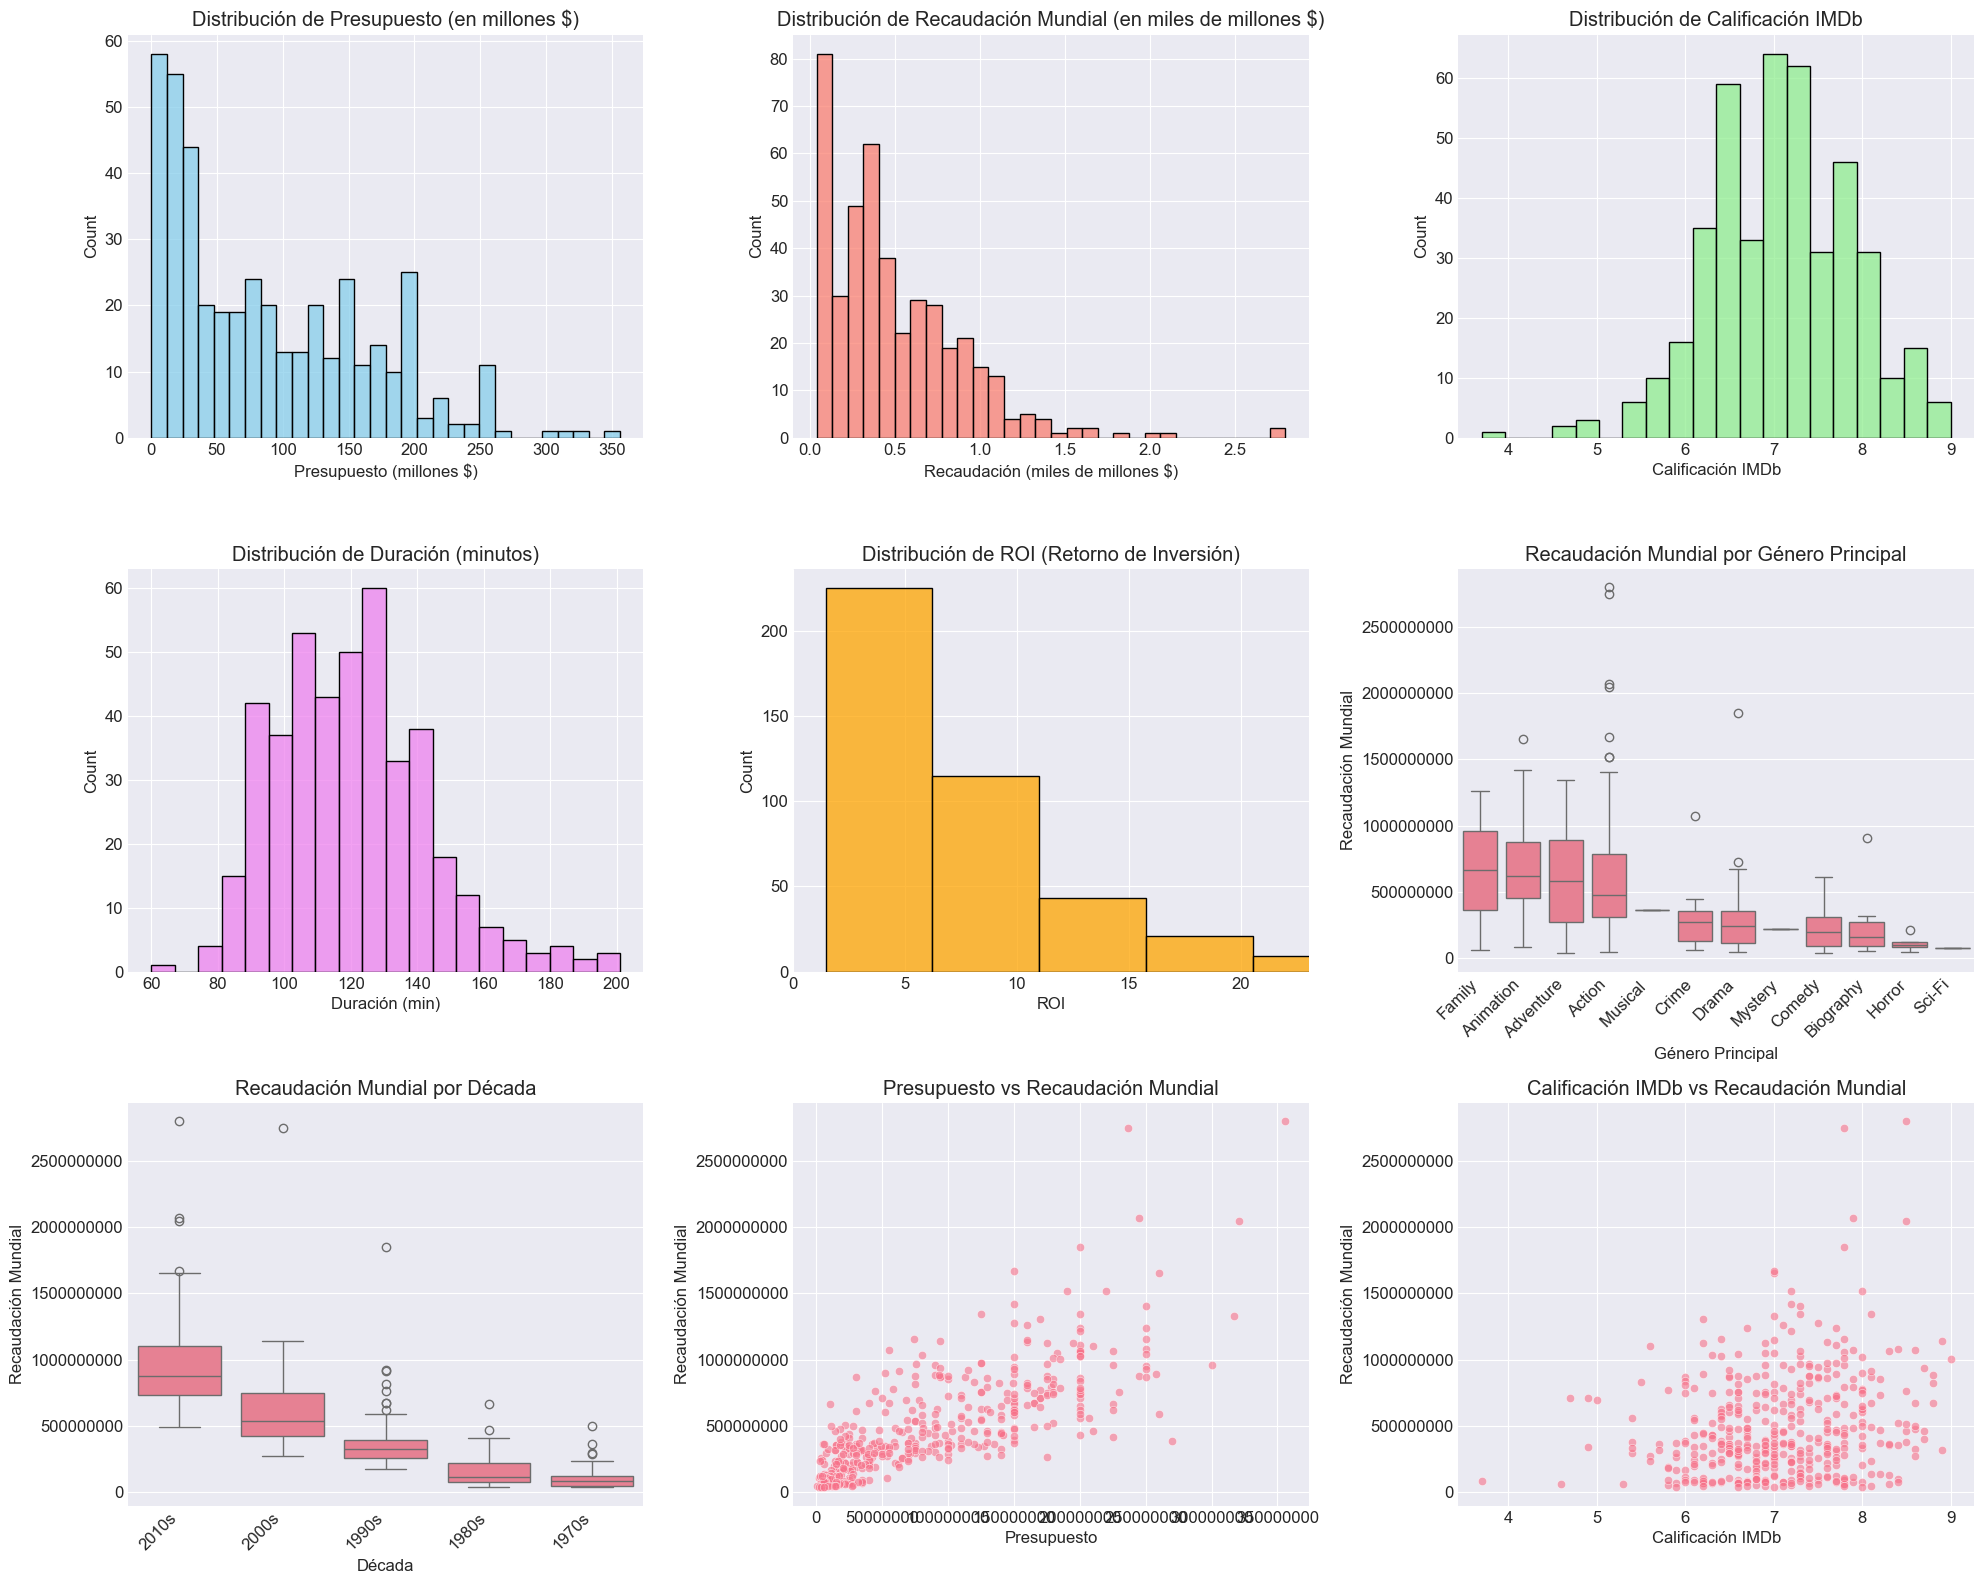

   4. Generando mapa de calor de correlaciones...
   ✓ Guardado: graphics/eda/Correlaciones_Variables.png


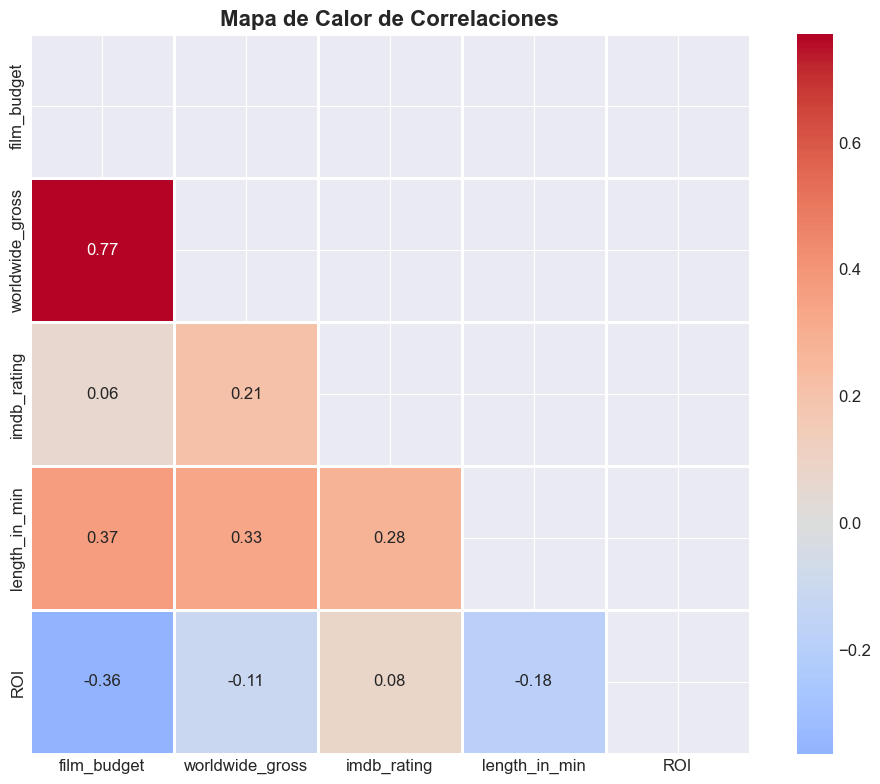

   5. Generando serie temporal...
   ✓ Guardado: graphics/eda/Serie_Temporal_Recaudacion.png


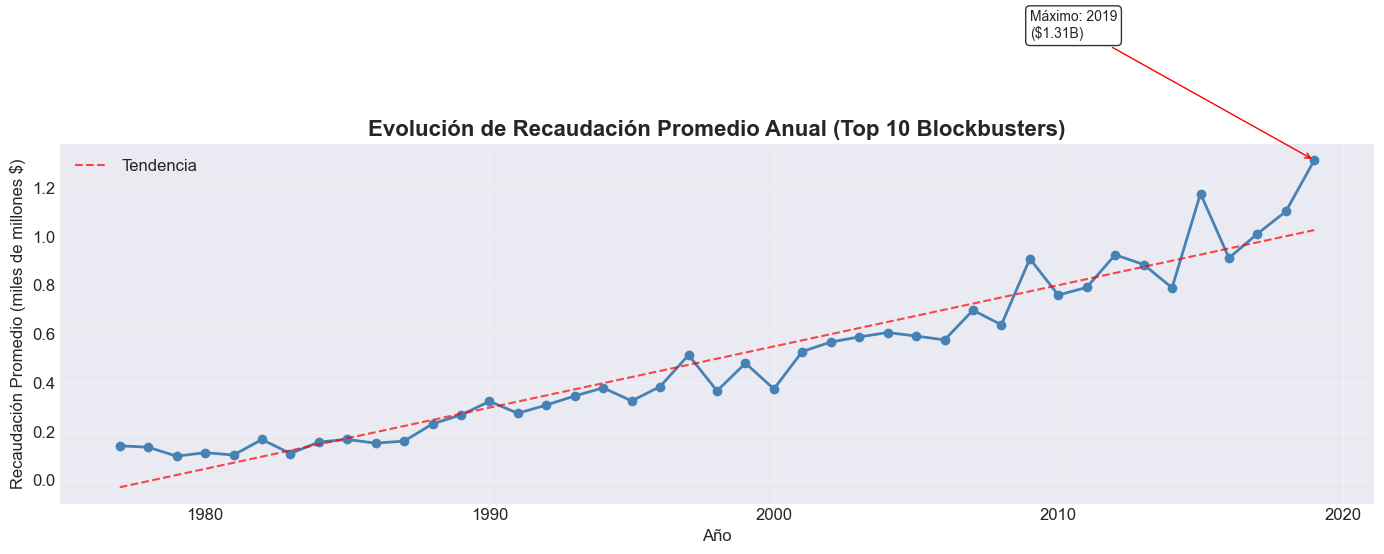

   6. Generando gráficos adicionales individuales...
   ✓ Guardado: graphics/eda/Top10_Recaudacion.png


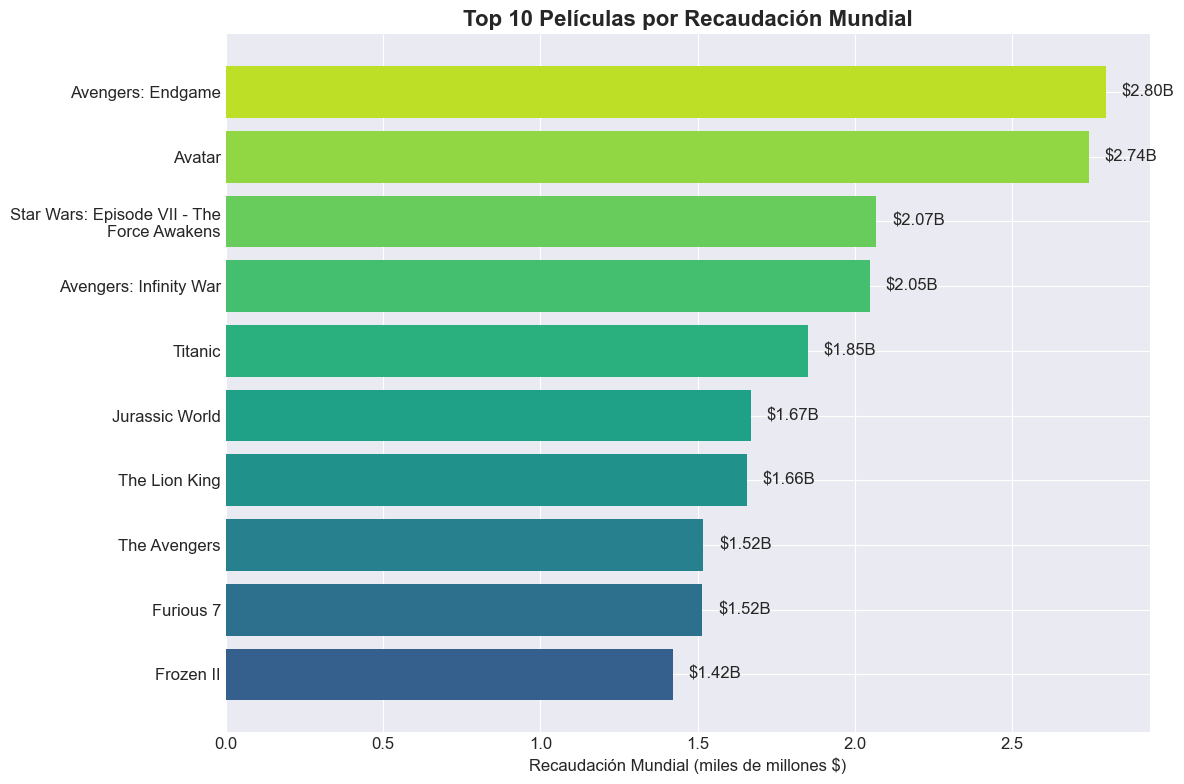


✓ Total de gráficos guardados: 4

💾 GUARDANDO DATOS PROCESADOS...
✓ Dataset limpio guardado como: data\Blockbusters_Limpio.csv
  • Filas: 430
  • Columnas: 18

📈 RESUMEN EJECUTIVO DEL ANÁLISIS

📅 PERÍODO ANALIZADO: 1977 - 2019
🎬 TOTAL DE PELÍCULAS: 430
📊 DÉCADAS CUBIERTAS: 5

💰 ESTADÍSTICAS FINANCIERAS PRINCIPALES:
  • Presupuesto promedio: $88.9 millones
  • Presupuesto máximo: $356.0 millones
  • Recaudación promedio: $0.50 mil millones
  • Recaudación máxima: $2.80 mil millones
  • ROI promedio: 9.14x
  • ROI máximo: 144.62x

🎭 DISTRIBUCIÓN POR GÉNERO:
  • Action: 194 películas (45.1%)
  • Comedy: 69 películas (16.0%)
  • Animation: 55 películas (12.8%)

📊 GRÁFICOS GENERADOS:
  • EDA_Visualizaciones_Principales.png
  • Correlaciones_Variables.png
  • Serie_Temporal_Recaudacion.png
  • Top10_Recaudacion.png

📁 ESTRUCTURA DE CARPETAS:
  • graphics/eda/ - Gráficos de análisis exploratorio
  • data/ - Datos procesados
  • results/ - Resultados de análisis (para notebooks específicos)



,release_year,rank_in_year,imdb_rating,mpaa_rating,film_title,film_budget,length_in_min,domestic_distributor,worldwide_gross,domestic_gross,genre_1,genre_2,genre_3,ROI,ROI_ratio,decade,decade_label,budget_category
0,2019,1,8.5,PG-13,Avengers: Endgame,356000000.0,181,Walt Disney,2.797801e+09,858373000.0,Action,Adventure,Drama,7.858990,7.858990,2010,2010s,Muy Alto (>200M)
1,2019,2,7.0,PG,The Lion King,260000000.0,118,Walt Disney,1.656943e+09,543638043.0,Animation,Adventure,Drama,6.372859,6.372859,2010,2010s,Muy Alto (>200M)
2,2019,3,7.2,PG,Frozen II,150000000.0,103,Walt Disney,1.420560e+09,470089732.0,Animation,Adventure,Comedy,9.470403,9.470403,2010,2010s,Alto (100-200M)
3,2019,4,7.6,PG-13,Spider-Man: Far from Home,160000000.0,129,Sony Pictures,1.131928e+09,390532085.0,Action,Adventure,Sci-Fi,7.074550,7.074550,2010,2010s,Alto (100-200M)
4,2019,5,6.9,PG-13,Captain Marvel,175000000.0,123,Walt Disney,1.128275e+09,426829839.0,Action,Adventure,Sci-Fi,6.447285,6.447285,2010,2010s,Alto (100-200M)



📊 TIPOS DE DATOS FINALES:
release_year               int64
rank_in_year               int64
imdb_rating              float64
mpaa_rating             category
film_title                object
film_budget              float64
length_in_min              int64
domestic_distributor    category
worldwide_gross          float64
domestic_gross           float64
genre_1                 category
genre_2                 category
genre_3                 category
ROI                      float64
ROI_ratio                float64
decade                     int64
decade_label              object
budget_category         category

📈 VARIABLES DERIVADAS CREADAS:
  • ROI
  • decade
  • decade_label
  • budget_category


In [8]:
def ejecutar_pipeline_analisis():
    """
    Ejecuta todo el pipeline de análisis
    """
    print("="*70)
    print("🎬 ANÁLISIS ESTADÍSTICO DE PELÍCULAS BLOCKBUSTER (1977-2019)")
    print("="*70)
    
    # Paso 0: Crear estructura de carpetas
    crear_estructura_carpetas()
    
    # Paso 1: Cargar datos
    df = cargar_datos()
    if df is None:
        print("❌ No se pudo cargar el dataset. Verifica el archivo.")
        return None
    
    # Paso 2: Limpieza y transformación
    df_clean = limpiar_y_transformar(df)
    
    # Paso 3: Análisis exploratorio
    analisis_exploratorio(df_clean)
    
    # Paso 4: Visualizaciones
    archivos_guardados = crear_visualizaciones(df_clean)
    
    # Paso 5: Guardar datos procesados
    guardado_exitoso, ruta_datos = guardar_datos_procesados(df_clean)
    
    if not guardado_exitoso:
        print("⚠ Advertencia: No se pudo guardar el dataset limpio")
    
    # Paso 6: Resumen ejecutivo
    crear_resumen_ejecutivo(df_clean, archivos_guardados)
    
    # Paso 7: Preparación para notebooks específicos
    print("\n" + "="*70)
    print("🚀 PREPARACIÓN PARA ANÁLISIS ESPECÍFICOS")
    print("="*70)
    
    print("\n📁 ESTRUCTURA FINAL DEL PROYECTO:")
    print("📂 Proyecto_Blockbusters/")
    print("   ├── 📁 graphics/")
    print("   │   ├── 📁 eda/                 # Gráficos de análisis exploratorio")
    print("   │   ├── 📁 pregunta1/           # Gráficos de regresión")
    print("   │   ├── 📁 pregunta2/           # Gráficos de correlación")
    print("   │   ├── 📁 pregunta3/           # Gráficos de clustering")
    print("   │   └── 📁 pregunta4/           # Gráficos de ANOVA")
    print("   ├── 📁 data/")
    print("   │   ├── Blockbusters_2019-1977.csv    # Datos originales")
    print("   │   └── Blockbusters_Limpio.csv       # Datos limpios")
    print("   ├── 📁 results/                # Resultados tabulares")
    print("   ├── 📓 Analisis_Blockbusters_Main.ipynb")
    print("   ├── 📓 Pregunta1_Regresion_Presupuesto_Recaudacion.ipynb")
    print("   ├── 📓 Pregunta2_Correlacion_IMDB_Recaudacion.ipynb")
    print("   ├── 📓 Pregunta3_Clustering_Peliculas.ipynb")
    print("   └── 📓 Pregunta4_ANOVA_Tendencias_Temporales.ipynb")
    
    print("\n🎯 PASOS SIGUIENTES:")
    print("  1. Ejecutar Pregunta1_Regresion_Presupuesto_Recaudacion.ipynb")
    print("  2. Ejecutar Pregunta2_Correlacion_IMDB_Recaudacion.ipynb")
    print("  3. Ejecutar Pregunta3_Clustering_Peliculas.ipynb")
    print("  4. Ejecutar Pregunta4_ANOVA_Tendencias_Temporales.ipynb")
    
    print("\n💡 CONSEJOS:")
    print("  • Cada notebook específico puede guardar sus gráficos en su carpeta correspondiente")
    print("  • Usa rutas relativas: 'graphics/pregunta1/mi_grafico.png'")
    print("  • Los datos limpios están en: 'data/Blockbusters_Limpio.csv'")
    
    return df_clean

if __name__ == "__main__":
    datos_procesados = ejecutar_pipeline_analisis()
    
    # Mostrar vista previa de los datos procesados
    if datos_procesados is not None:
        print("\n" + "="*70)
        print("👁️  VISTA PREVIA DE DATOS PROCESADOS (primeras 5 filas)")
        print("="*70)
        
        # Configurar pandas para mostrar más columnas
        pd.set_option('display.max_columns', None)
        display(datos_procesados.head())
        
        print("\n📊 TIPOS DE DATOS FINALES:")
        print(datos_procesados.dtypes.to_string())
        
        print("\n📈 VARIABLES DERIVADAS CREADAS:")
        nuevas_variables = ['ROI', 'decade', 'decade_label', 'budget_category']
        for var in nuevas_variables:
            if var in datos_procesados.columns:
                print(f"  • {var}")